# Importing Libraries 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch import optim,nn
from torch.utils.data.dataset import Dataset
from torchvision import transforms 
from export import load_cifar10_data
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

# Model Archietechture 

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DenoisingAutoencoder(nn.Module):
    def __init__(self, latent_dim=128):
        """
        Denoising Autoencoder for CIFAR-10 images
        Args:
            latent_dim (int): Dimension of the latent space
        """
        super(DenoisingAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 16x16
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 8x8
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 4x4
            
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, latent_dim),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128 * 4 * 4),
            nn.ReLU(),
            
            nn.Unflatten(1, (128, 4, 4)),
            
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),  # 8x8
            nn.ReLU(),
            
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),   # 16x16
            nn.ReLU(),
            
            nn.ConvTranspose2d(32, 3, kernel_size=2, stride=2),    # 32x32
            nn.Sigmoid()  # Output values between [0,1]
        )

    def add_noise(self, x, noise_factor):
        """Add Gaussian noise to input images"""
        noise = torch.randn_like(x) * noise_factor
        noisy_x = x + noise
        return torch.clamp(noisy_x, 0., 1.)
    
    def forward(self, x, noise_factor):
        """
        Forward pass
        Args:
            x (torch.Tensor): Input images [B, C, H, W]
            noise_factor (float): Standard deviation of Gaussian noise
        """
        # Add noise to input
        noisy_x = self.add_noise(x, noise_factor)
        
        # Encode noisy input
        latent = self.encoder(noisy_x)
        
        # Decode to reconstruct original
        reconstructed = self.decoder(latent)
        
        return reconstructed, noisy_x, latent
    
    def encode(self, x):
        """Encode input to latent space"""
        return self.encoder(x)
    
    def decode(self, z):
        """Decode latent vectors to images"""
        return self.decoder(z)

class Encoder(nn.Module):
    def __init__(self, in_channels=3, latent_dim=256):
        super(Encoder, self).__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 32x32 -> 16x16

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 16x16 -> 8x8

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) # 8x8 -> 4x4
        )

        self.flatten = nn.Flatten()
        self.fc = nn.Linear(256*4*4, latent_dim)

    def forward(self, x):
        x = self.conv_op(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_dim=256, out_channels=3):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 256*4*4)
        self.conv_op = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2), # 4x4 -> 8x8
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2), # 8x8 -> 16x16
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, out_channels, kernel_size=2, stride=2), # 16x16 -> 32x32
            nn.Sigmoid() # Pixel values in range [0, 1]
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 256, 4, 4)
        x = self.conv_op(x)
        return x

class AutoEncoder(nn.Module):
    def __init__(self, in_channles=3,latent_dim=256):
        super(AutoEncoder,self).__init__()
        self.encoder=Encoder(in_channles,latent_dim)
        self.decoder=Decoder(latent_dim,in_channles)
    def forward(self,x):
        x=self.encoder(x)
        x=self.decoder(x)
        return x

In [3]:
if (torch.cuda.is_available):
    device="cuda"
    if device=="cuda":
        num_workers=torch.cuda.device_count() * 1
        print(num_workers)
        print(torch.cuda.get_device_name())
else:
    print("cuda is not availabel")
    device= "cpu"

1
NVIDIA RTX A5000


# Data Loding 

In [4]:
(train_images, train_labels), (test_images, test_labels), class_names = load_cifar10_data()

print(f"Training images shape: {train_images.shape}") 
print(f"Training labels shape: {train_labels.shape}") 
print(f"Test images shape: {test_images.shape}")     
print(f"Test labels shape: {test_labels.shape}")

class CIFAR10Dataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    transforms.RandomHorizontalFlip(p=0.5)
])

train_dataset = CIFAR10Dataset(train_images, train_labels, transform=transform)
test_dataset = CIFAR10Dataset(test_images, test_labels, transform=transform)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Train loader: {train_loader}")
print(f"Test loader: {test_loader}")


# Training Model DAE

In [5]:
def train_epoch_dae(model, dataloader, val_loader, criterion, optimizer, device, noise_factor, n_epochs):
    """Train for one epoch and track losses"""
    train_losses = []
    val_losses = []
    
    for epoch in range(n_epochs):
        # Training
        model.train()
        total_loss = 0
        pbar = tqdm(dataloader, desc=f'Training Epoch {epoch+1}/{n_epochs}')
        
        for batch_idx, (data, _) in enumerate(pbar):
            data = data.to(device)
            optimizer.zero_grad()
            
            # Forward pass
            reconstructed, noisy_x, _ = model(data, noise_factor)
            
            # Compute reconstruction loss
            loss = criterion(reconstructed, data)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            pbar.set_description(f'Training (loss={loss.item():.4f})')
        
        train_loss = total_loss / len(dataloader)
        train_losses.append(train_loss)
        
        # Validation
        val_loss = evaluate_dae(model, val_loader, criterion, device, noise_factor)
        val_losses.append(val_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{n_epochs}")
            print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    return model, train_losses, val_losses

@torch.no_grad()
def evaluate_dae(model, dataloader, criterion, device, noise_factor):
    """Evaluate model"""
    model.eval()
    total_loss = 0
    
    pbar = tqdm(dataloader, desc='Evaluating')
    for batch_idx, (data, _) in enumerate(pbar):
        data = data.to(device)
        
        # Forward pass
        reconstructed, noisy_x, _ = model(data, noise_factor)
        
        # Compute reconstruction loss
        loss = criterion(reconstructed, data)
        total_loss += loss.item()
        pbar.set_description(f'Evaluating (loss={loss.item():.4f})')
        
    return total_loss / len(dataloader)

# Training Model AE

In [6]:
def train_epoch_ae(model, dataloader, criterion, optimizer, device,epochs):
    # epochs = 20
    outputs = []
    losses = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(epochs):
        for batch_idx, (images, _) in enumerate(dataloader):  # Get images from train_loader
            images = images.to(device, dtype=torch.float32)  # Send to GPU/CPU

            output = model(images)
            loss = criterion(output, images)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(loss.item())

            # Print loss every 100 batches to reduce console clutter
            if batch_idx % 100 == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Step [{batch_idx}/{len(dataloader)}], Loss: {loss.item():.4f}")

    print("Training Complete!")
    return model, losses

def evaluate_ae(model, dataloader, criterion,device):
    model.eval()

    # Get test images and reconstructed images
    test_images, _ = next(iter(dataloader))  # Fetch a batch from test_loader
    test_images = test_images.to(device)

    with torch.no_grad():
        reconstructed_images = model(test_images)

    # Convert tensors to numpy for evaluation
    test_images_np = test_images.cpu().detach().numpy()
    reconstructed_images_np = reconstructed_images.cpu().detach().numpy()

    # Function to evaluate reconstruction quality
    def evaluate_reconstruction(original, reconstructed):
        batch_size = original.shape[0]
        ssim_scores, psnr_scores, mae_scores, mse_scores = [], [], [], []

        for i in range(batch_size):
            orig = np.transpose(original[i], (1, 2, 0))  # Convert (C, H, W) → (H, W, C)
            recon = np.transpose(reconstructed[i], (1, 2, 0))

            ssim_scores.append(ssim(orig, recon, channel_axis=-1, data_range=1.0, win_size=3))
            psnr_scores.append(psnr(orig, recon, data_range=1.0))
            mae_scores.append(np.mean(np.abs(orig - recon)))
            mse_scores.append(np.mean((orig - recon) ** 2))

        return {
            "SSIM": np.mean(ssim_scores),
            "PSNR": np.mean(psnr_scores),
            "MAE": np.mean(mae_scores),
            "MSE": np.mean(mse_scores),
        }

    # Get the evaluation results
    # metrics = evaluate_reconstruction(test_images_np, reconstructed_images_np)
    # print("Evaluation Results:", metrics)s

### parameters and model paths 

In [7]:
n_epochs = 30
noise_factors = [0.1,0.3,0.5]
# Path('models') / f'denoising_autoencoder_0.1.pth'
model_paths = {
    'ae': Path('models') / f'autoencoder.pth',
    0.1: Path('models') / f'denoising_autoencoder_0.1.pth',
    0.3: Path('models') / f'denoising_autoencoder_0.3.pth',
    0.5: Path('models') / f'denoising_autoencoder_0.5.pth'
}


## Initilizing the model 
### autoencoder

In [ ]:
model = AutoEncoder(in_channles=3,latent_dim=256)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
model, train_loss = train_epoch_ae(model, train_loader, criterion, optimizer, device,n_epochs)
val_loss = evaluate_ae(model, test_loader, criterion, device)
model_save_path = Path('models/autoencoder.pth').resolve()
torch.save(model.state_dict(), model_save_path)

## Initilizing the model 
### denoising autoencoder

In [ ]:
model = DenoisingAutoencoder(latent_dim=128).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
losses = {}
for noise_factor in noise_factors:
    print(f"\nTraining with noise factor {noise_factor}")
    model, train_losses, val_losses = train_epoch_dae(
        model, 
        train_loader, 
        test_loader,  # Using test_loader as validation
        criterion, 
        optimizer, 
        device, 
        noise_factor,
        n_epochs
    )

    losses[noise_factor] = {
        'train': train_losses,
        'val': val_losses
    }
    model_save_path = Path('models') / f'denoising_autoencoder_{noise_factor}.pth'
    torch.save(model.state_dict(), model_save_path)
    # torch.save(model.state_dict(), f'Assignment-2/models/denoising_autoencoder_{noise_factor}.pth')


### Visuvalisations

In [10]:
def visualize_reconstruction(models, test_loader, num_images=8):
    """Visualize original, noisy and reconstructed images from multiple models"""
    num_models = len(models)
    fig, axes = plt.subplots(num_models * 2, num_images, figsize=(20, num_models * 3))
    plt.subplots_adjust(wspace=0.01, hspace=0.15)

    with torch.no_grad():
        images, _ = next(iter(test_loader))
        images = images.to(device)

        for idx, (model_name, model) in enumerate(models.items()):
            model.eval()
            model.to(device)
            
            # Add row labels on the left
            if model_name == 'ae':
                fig.text(0.02, 0.73 - (idx * 0.25), 'AutoEncoder', 
                        fontsize=12, rotation=90, va='center')
                reconstructed = model(images)
                images_np = images.cpu().numpy()
                reconstructed_np = reconstructed.cpu().numpy()
            else:
                # Extract noise factor from model name (which is now a string)
                current_noise = float(model_name)
                fig.text(0.02, 0.73 - (idx * 0.25), f'DAE (σ={current_noise})', 
                        fontsize=12, rotation=90, va='center')
                reconstructed, noisy, _ = model(images, current_noise)
                noisy_np = noisy.cpu().numpy()
                reconstructed_np = reconstructed.cpu().numpy()
            
            for i in range(num_images):
                # Remove axis spines and increase image size
                for spine in ['top', 'right', 'bottom', 'left']:
                    axes[idx * 2, i].spines[spine].set_visible(False)
                    axes[idx * 2 + 1, i].spines[spine].set_visible(False)
                
                if model_name == 'ae':
                    axes[idx * 2, i].imshow(np.transpose(images_np[i], (1, 2, 0)))
                else:
                    axes[idx * 2, i].imshow(np.transpose(noisy_np[i], (1, 2, 0)))
                
                axes[idx * 2, i].set_xticks([])
                axes[idx * 2, i].set_yticks([])
                
                axes[idx * 2 + 1, i].imshow(np.transpose(reconstructed_np[i], (1, 2, 0)))
                axes[idx * 2 + 1, i].set_xticks([])
                axes[idx * 2 + 1, i].set_yticks([])
            
            # Set titles
            if model_name == 'ae':
                axes[idx * 2, 0].set_title("Original Input", pad=2, fontsize=10)
                axes[idx * 2 + 1, 0].set_title("Reconstructed Output", pad=2, fontsize=10)
            else:
                axes[idx * 2, 0].set_title(f"Noisy Input (σ={current_noise})", pad=2, fontsize=10)
                axes[idx * 2 + 1, 0].set_title("Denoised Output", pad=2, fontsize=10)

    fig.suptitle('Reconstruction Results: AutoEncoder vs Denoising AutoEncoder', 
                 fontsize=14, y=0.95)
    plt.tight_layout(rect=[0.03, 0, 1, 0.95])
    
    plt.savefig(Path('images') / f'reconstruction_comparison_all.png', 
                bbox_inches='tight', dpi=300, pad_inches=0.2)
    plt.show()
def epoch_vs_loss(losses):
    """Plot training and validation losses for each noise factor"""
    plt.figure(figsize=(10, 6))
    
    for noise_factor, loss in losses.items():
        plt.plot(loss['train'], label=f'Train Loss (Noise {noise_factor})')
        plt.plot(loss['val'], label=f'Val Loss (Noise {noise_factor})')
    
    plt.title('Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    
    plt.savefig(Path('images') / f'loss_vs_epoch.png')
    plt.show()

### Loading the model for visuvalisations

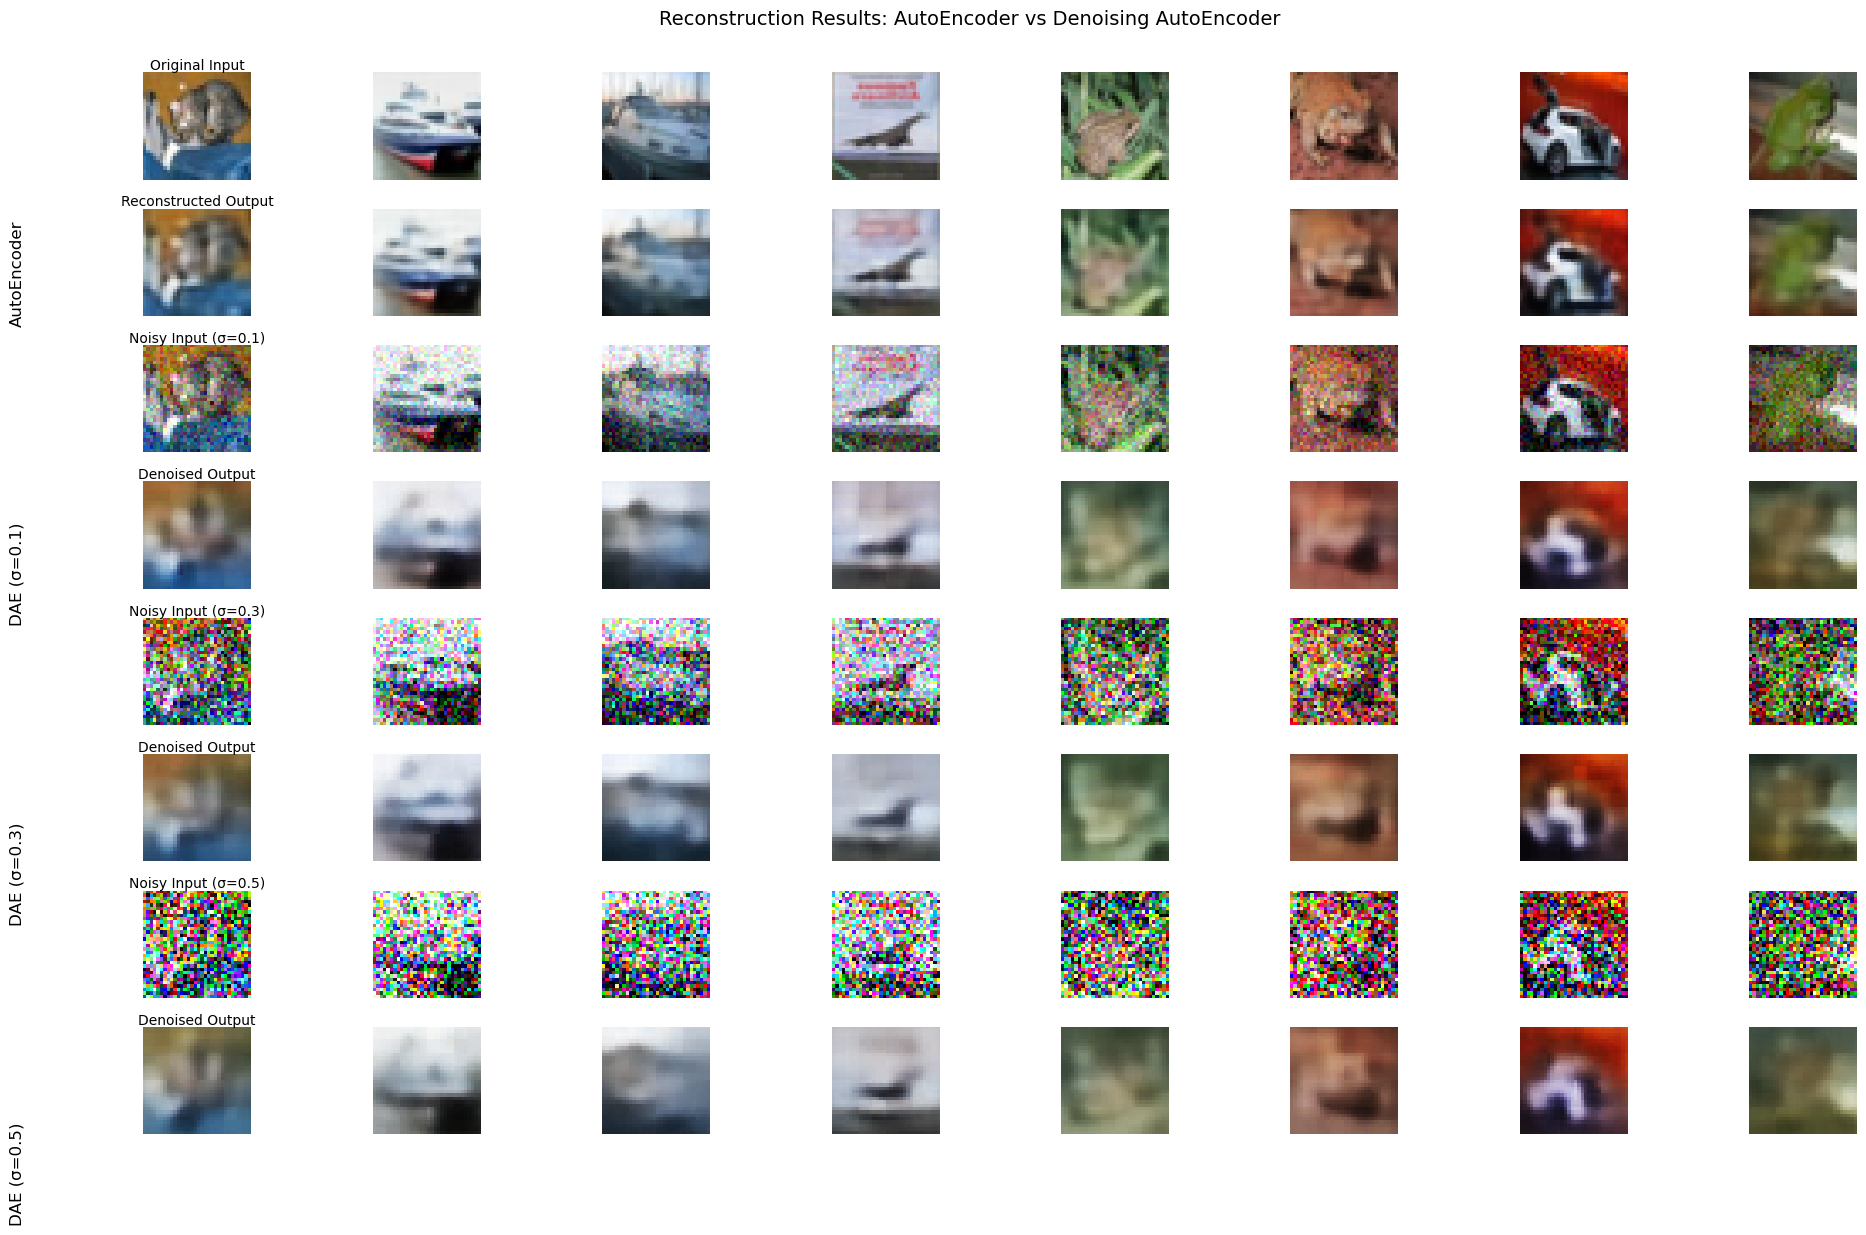

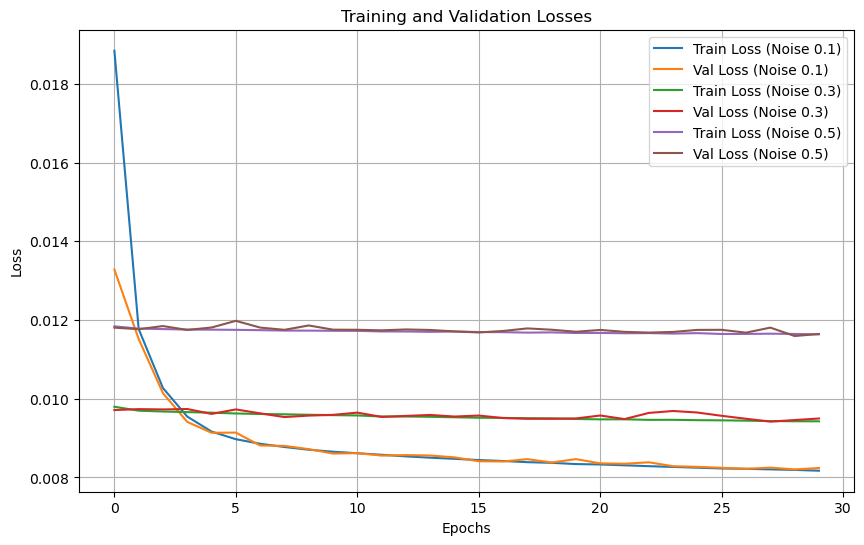

In [11]:
models = {}
# losses['ae'] = {'train': train_loss, 'val': val_loss}
for name, path in model_paths.items():
    model = DenoisingAutoencoder(latent_dim=128).to(device) if name != 'ae' else AutoEncoder(in_channles=3, latent_dim=256).to(device)
    model.load_state_dict(torch.load(path, weights_only=True))
    models[str(name)] = model
# print(models.items())
# Call visualize_reconstruction
visualize_reconstruction(models,test_loader=test_loader, num_images=8)
epoch_vs_loss(losses)